In this post, I will describe how to use [BSON-NumPy](https://github.com/mongodb/bson-numpy/) to pull data out of [Mongo](https://www.mongodb.com/) and into [pandas](http://pandas.pydata.org/pandas-docs/stable/). While this library is still in the prototype stage, it's hard to to ignore the [10x](https://talkpython.fm/episodes/show/103/compiling-python-through-pyllvm-and-mongodb-for-data-scientists) speed improvement that comes from reading [BSON](https://en.wikipedia.org/wiki/BSON) documents directly into [NumPy](http://www.numpy.org/).

For this example, I will be analyzing a collection of [my tweets](https://twitter.com/CaiusSivjus) stored in a MongoDB instance running on MLab.

**Note**: BSON-Numpy is [under active development](https://github.com/mongodb/bson-numpy); API is subject to change.

---

## What You Need to Follow Along

### Development Tools (Stack)

* [Python 3](https://www.python.org/downloads/)
* [MongoDB](https://docs.mongodb.com/manual/installation/) (local or online instance)
* [MongoDB C Driver](https://github.com/mongodb/mongo-c-driver)
* [BSON-NumPy](http://bson-numpy.readthedocs.io/en/latest/#installing)
* PyData stack ([Pandas](http://pandas.pydata.org/pandas-docs/stable/install.html), [matplotlib](http://matplotlib.org/users/installing.html), [seaborn](http://seaborn.pydata.org/installing.html))

### Code
* [Jupyter Notebook on Github](https://github.com/alysivji/blog-notebooks/tree/master/mongodb-bson-numpy-twitter-analysis)

---

## Setting up Environment

In [1]:
# standard library
from collections import namedtuple
import os

# pydata
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# bson-numpy libraries
import numpy as np
from bson import CodecOptions
from bson.raw_bson import RawBSONDocument
from pymongo import MongoClient
import bsonnumpy

# other libraries
import maya

In [2]:
# get mongodb params from environment
mlab_uri = os.getenv('MLAB_URI')
mlab_collection = os.getenv('MLAB_COLLECTION')

---

## Overview of Data & Schema

Twitter is a [microblogging](https://en.wikipedia.org/wiki/Microblogging) platform that allows users to post content, aka _tweets_, that are limited to 280 characters. There are two types of tweets: tweets you write ("original tweets") and tweets that other people write & you repost ("retweets").

Every 12 hours, an AWS Lambda function goes out and downloads [my latest tweets](https://www.twitter.com/CaiusSivjus) and stores them in a Mongo collection. The script leverages the [Tweepy](tweepy.readthedocs.io) API wrapper, which does introduce some quirks to the process.

Let's start off by looking at the data we have inside Mongo.

### Original Tweets

Looks like we can capture the full text of the tweet from the appropriately named `full_text` field:

<img src="/tree/images/21-30/22_original_tweet_schema.png" alt="Schema for original tweet" width=800 />

### Retweets

The `full_text` field is cut off, but it appears that the nested `retweeted_status.full_text` field has everything we are looking for.

<img src="/tree/images/21-30/22_retweet_tweet_schema.png" alt="Schema for rewtweet" width=850 />

There is currently no way of [handling varied documents](https://github.com/mongodb/bson-numpy/issues/40) using BSON-NumPy; we'll have to pull our data separately and combine it with pandas.

We can use the [`$exists`](https://docs.mongodb.com/manual/reference/operator/query/exists/) operator in our [query](https://docs.mongodb.com/manual/reference/operator/query/) as follows:

1. `.find({"retweeted_status": {"$exists": False}})`
1. `.find({"retweeted_status": {"$exists": True}})`

---

## Downloading Data

Set up the connection to Mongo:

In [3]:
codec_options=CodecOptions(document_class=RawBSONDocument)
client = MongoClient(mlab_uri)
db = client.get_default_database()
collection = db.get_collection(
    mlab_collection,
    codec_options=codec_options
)

We'll have to define a [`np.dtype`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dtype.html#numpy.dtype) variable which specifies:
* the fields to extract from Mongo
* the NumPy types to convert to

This variable has to match the structure of the MongoDB document. If we want to pull a nested field, we will need to define a variable with a nested structure.

### Original Tweets

In [4]:
dtype_original = np.dtype(
    [
        ('full_text', 'S400'),
        ('created_at', 'S64'),
    ]
)

In [5]:
# query Mongo (using a generator expression)
ndarray_original = bsonnumpy.sequence_to_ndarray(
    (doc.raw for doc in collection.find({"retweeted_status": {"$exists": False}})), 
    dtype_original, 
    collection.count(),
)

In [6]:
print(ndarray_original[:2])

[ (b'Still. API keys in ipython notebooks! Yikes', b'Sat Dec 16 21:23:32 +0000 2017')
 (b'Fixing up a project I worked on in April 2016. Good job me for documenting sorta well', b'Sat Dec 16 21:22:47 +0000 2017')]


In [7]:
tweets_original = pd.DataFrame(ndarray_original)

In [8]:
# convert bytes to string!
tweets_original['full_text'] = tweets_original['full_text'].str.decode('utf-8')
tweets_original['created_at'] = tweets_original['created_at'].str.decode('utf-8')

In [9]:
tweets_original.head()

,full_text,created_at
0,Still. API keys in ipython notebooks! Yikes,Sat Dec 16 21:23:32 +0000 2017
1,Fixing up a project I worked on in April 2016....,Sat Dec 16 21:22:47 +0000 2017
2,https://t.co/6Ubtx6S1O8\n#bookmark,Sat Dec 16 20:45:00 +0000 2017
3,VSCode November release \nhttps://t.co/U4nzPLE8QI,Sat Dec 16 20:23:18 +0000 2017
4,@TooManyNickLees It does for this project I'm ...,Sat Dec 16 20:08:26 +0000 2017


### Retweets

In [10]:
dtype_rt = np.dtype(
    [
        ('retweeted_status', np.dtype([('full_text', 'S400')])),
        ('created_at', 'S64'),
    ]
)

In [11]:
ndarray_rt = bsonnumpy.sequence_to_ndarray(
    (doc.raw for doc in collection.find({"retweeted_status": {"$exists": True}})), 
    dtype_rt, 
    collection.count(),
)

In [12]:
tweets_rt = pd.DataFrame(ndarray_rt)

In [13]:
tweets_rt['full_text'] = tweets_rt['retweeted_status'].map(lambda value: value[0].decode('utf-8'))
tweets_rt['created_at'] = tweets_rt['created_at'].str.decode('utf-8')

In [14]:
tweets_rt.head()

,retweeted_status,created_at,full_text
0,(b'A list of things that might be useful when ...,Sat Dec 16 20:29:52 +0000 2017,A list of things that might be useful when ans...
1,(b'OUT: import pdb; pdb.set_trace()\nIN: break...,Sat Dec 16 20:08:52 +0000 2017,OUT: import pdb; pdb.set_trace()\nIN: breakpoi...
2,"(b'Great news, Guido has pronounced dicts to r...",Sat Dec 16 16:46:55 +0000 2017,"Great news, Guido has pronounced dicts to reta..."
3,(b'First ever PyCon happening in Pakistan http...,Sat Dec 16 13:46:57 +0000 2017,First ever PyCon happening in Pakistan https:/...
4,(b'#python news: \xf0\x9f\x98\x80 @gvanrossum...,Sat Dec 16 05:14:45 +0000 2017,#python news: 😀 @gvanrossum just pronounced t...


---

## Combine Datasets

In [15]:
len(tweets_original) + len(tweets_rt)

2611

In [16]:
tweets = pd.concat([tweets_rt, tweets_original])

In [17]:
len(tweets)

2611

In [18]:
tweets['retweeted'] = tweets['retweeted_status'].notna()
tweets = tweets.drop(columns=['retweeted_status'])

In [19]:
tweets.describe(include='all')

,created_at,full_text,retweeted
count,2611,2611,2611
unique,2611,2604,2
top,Mon May 22 01:46:23 +0000 2017,How I Git\n{author: @amention }\nhttps://t.co/...,False
freq,1,2,1595


### Add Additional Information to Data

* Parse datatime and convert to correct timezone (assumption: most of my tweets were made around Chicago)
* Add tweet character count 

In [20]:
ConvertTZArgs = namedtuple("ConvertTZArgs", ["dt_col", "to_timezone"])

def convert_timezone(row, *args):
    # get datetime
    dt_col = args[0].dt_col
    to_timezone = args[0].to_timezone
    dt = row[dt_col]
    
    dt = maya.parse(dt).datetime(to_timezone=to_timezone)
    return dt

In [21]:
tweets['created_at'] = tweets.apply(
    convert_timezone,
    axis=1, 
    args=(ConvertTZArgs('created_at', 'US/Central'),)
)

In [22]:
tweets['chars'] = tweets['full_text'].str.len()

In [23]:
tweets.head()

,created_at,full_text,retweeted,chars
0,2017-12-16 14:29:52-06:00,A list of things that might be useful when ans...,True,166
1,2017-12-16 14:08:52-06:00,OUT: import pdb; pdb.set_trace()\nIN: breakpoi...,True,90
2,2017-12-16 10:46:55-06:00,"Great news, Guido has pronounced dicts to reta...",True,246
3,2017-12-16 07:46:57-06:00,First ever PyCon happening in Pakistan https:/...,True,62
4,2017-12-15 23:14:45-06:00,#python news: 😀 @gvanrossum just pronounced t...,True,137


---

## Explore and Analyze Data

In [24]:
tweets['retweeted'].value_counts()

False    1595
True     1016
Name: retweeted, dtype: int64

### Investigating Number of Characters

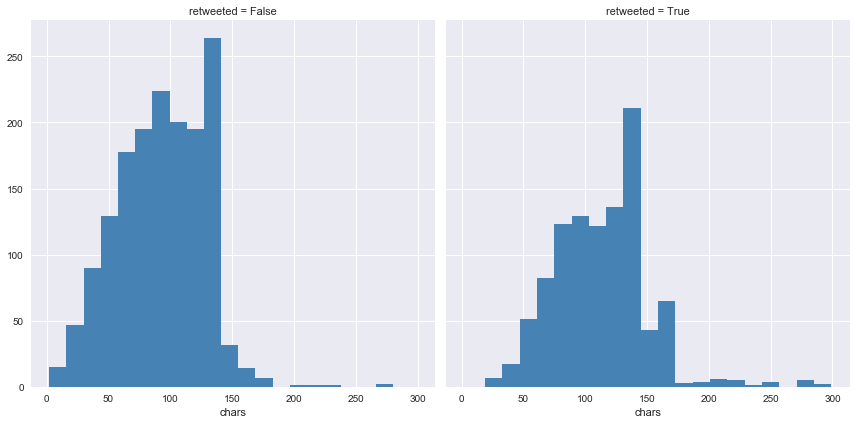

In [25]:
g = sns.FacetGrid(
    tweets,
    col="retweeted",
    margin_titles=True,
    size=6,
)

g.map(
    plt.hist,
    "chars",
    bins=20,
    color="steelblue",
    lw=0,
)

In [26]:
tweets[tweets['retweeted'] == 0]['chars'].describe()

count    1595.000000
mean       93.228840
std        35.649305
min         2.000000
25%        67.000000
50%        95.000000
75%       122.000000
max       280.000000
Name: chars, dtype: float64

In [27]:
tweets[tweets['retweeted'] == 1]['chars'].describe()

count    1016.000000
mean      112.819882
std        38.045216
min        19.000000
25%        85.000000
50%       115.000000
75%       137.000000
max       299.000000
Name: chars, dtype: float64

### Examining Time Between Posts

In [28]:
# creating function
def time_between(times):
    sorted_times = times.sort_values()
    time_between = sorted_times - sorted_times.shift(1)
    return time_between

In [29]:
def to_seconds(time):
    return time / np.timedelta64(1, 's')

#### Original Tweets

In [30]:
between_my_posts = time_between(tweets[tweets['retweeted'] == 0]['created_at'])

In [31]:
between_my_posts.describe()

count                      1594
mean     1 days 03:26:02.309912
std      2 days 10:13:51.045480
min             0 days 00:00:08
25%      0 days 01:50:48.500000
50%      0 days 08:17:50.500000
75%      1 days 00:33:25.500000
max            31 days 21:24:50
Name: created_at, dtype: object

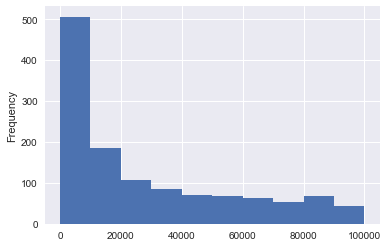

In [32]:
to_seconds(between_my_posts).plot(
    kind='hist',
    range=(0, 100_000)
)

#### All Tweets (Original Tweets + Retweets)

In [33]:
between_all_posts = time_between(tweets['created_at'])

In [34]:
between_all_posts.describe()

count                      2610
mean     0 days 16:45:16.904980
std      1 days 17:19:51.559515
min             0 days 00:00:03
25%      0 days 00:43:58.750000
50%             0 days 03:09:13
75%             0 days 13:47:39
max            26 days 03:23:07
Name: created_at, dtype: object

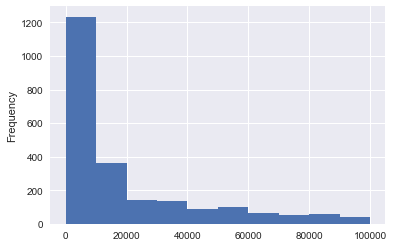

In [35]:
to_seconds(between_all_posts).plot(
    kind='hist',
    range=(0, 100_000)
)

### Twitter Activity Heatmap

What time of the week am I most activate on Twitter? We'll use [`seaborn.heatmap`](https://seaborn.pydata.org/generated/seaborn.heatmap.html) to explore this in more detail.

In [36]:
tweets['hour'] = tweets['created_at'].dt.hour
tweets['day_of_week'] = tweets['created_at'].dt.dayofweek
days_of_week = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

#### All Tweets (Original Tweets + Retweets)

In [37]:
tweets_timeline = tweets.groupby(by=['hour', 'day_of_week'])['full_text'].count()

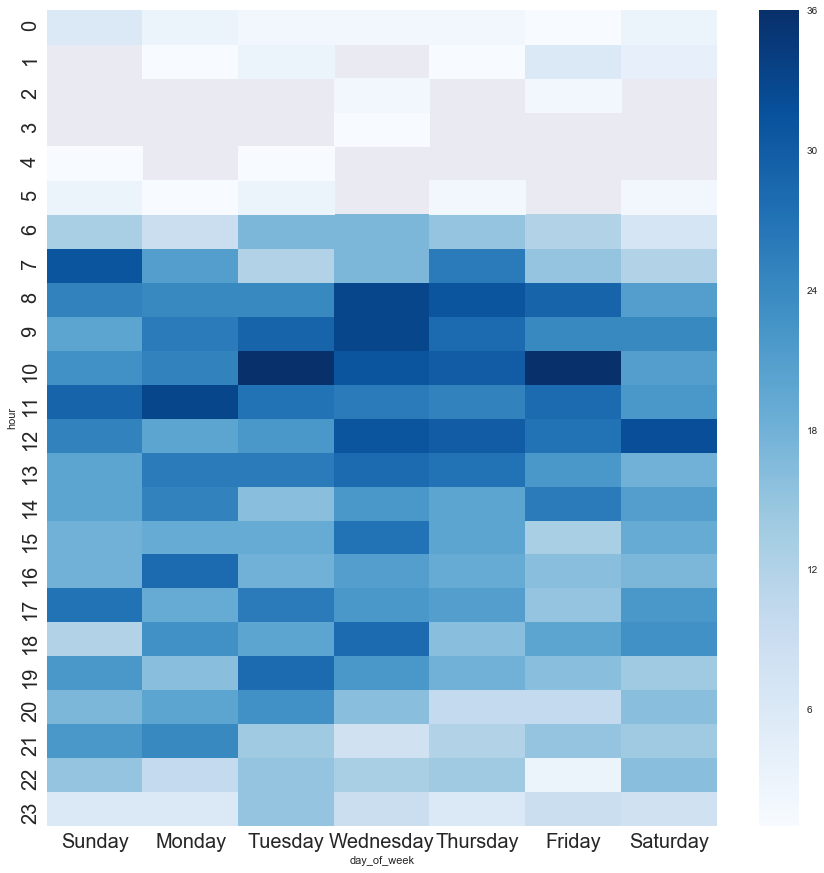

In [38]:
plt.figure(figsize=(15, 15))
ax = (sns.heatmap(tweets_timeline.unstack(),
                  cmap='Blues',
                  xticklabels=days_of_week))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)

#### Original Tweets

In [39]:
tweets_timeline = tweets[tweets['retweeted'] == 0].groupby(by=['hour', 'day_of_week'])['full_text'].count()

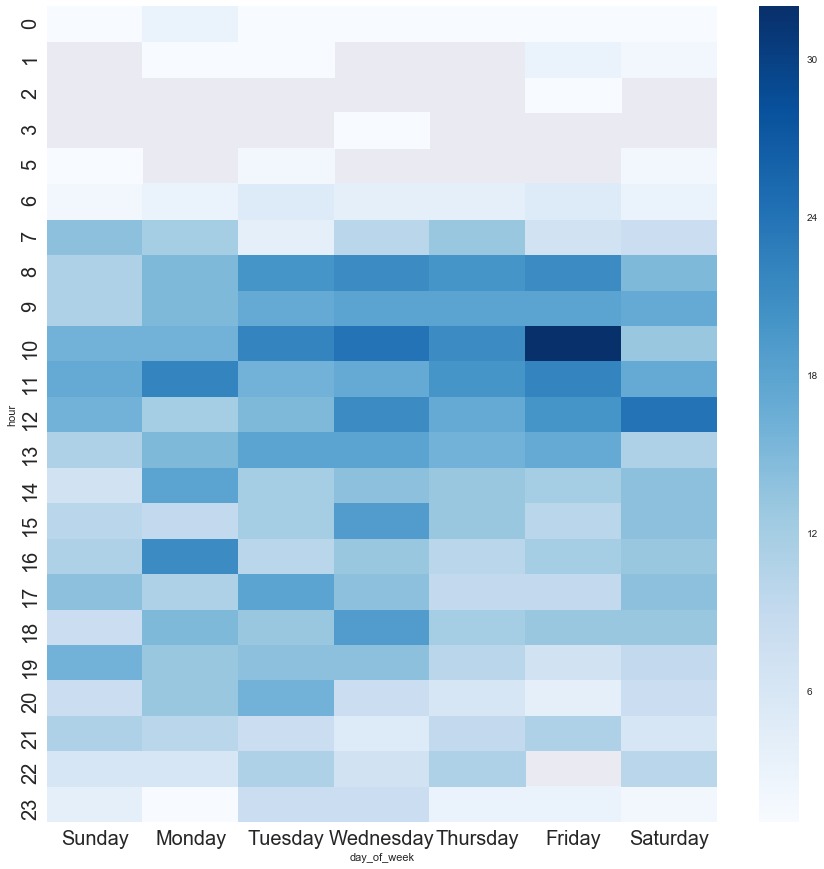

In [40]:
plt.figure(figsize=(15, 15))
ax = (sns.heatmap(tweets_timeline.unstack(),
                  cmap='Blues',
                  xticklabels=days_of_week))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)

### Retweets

In [41]:
tweets_timeline = tweets[tweets['retweeted'] == 1].groupby(by=['hour', 'day_of_week'])['full_text'].count()

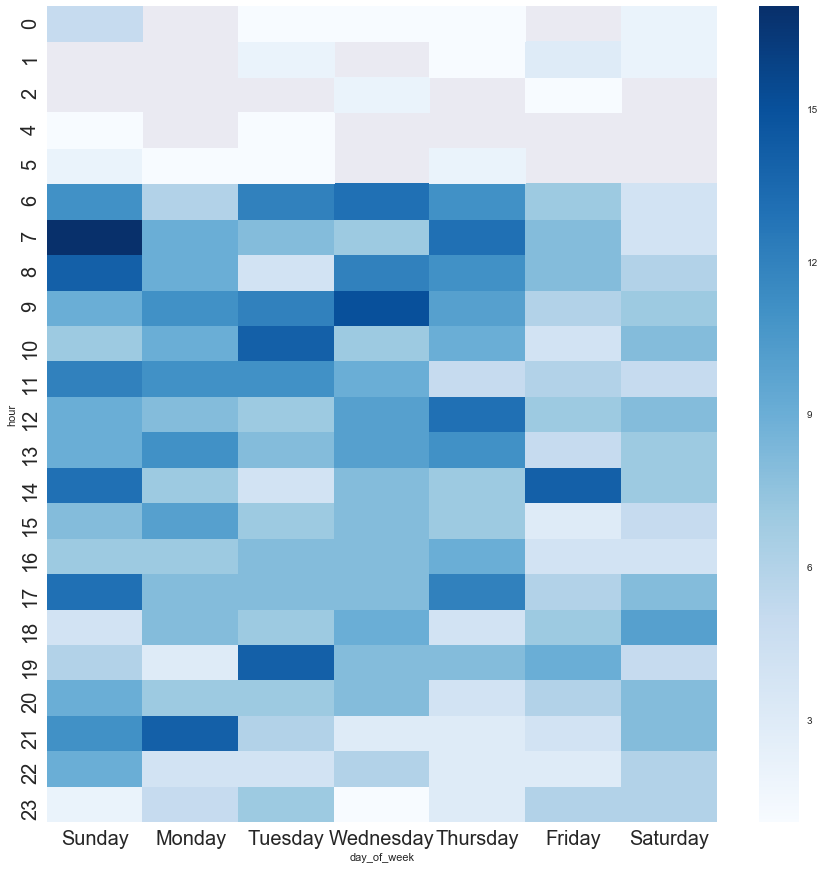

In [42]:
plt.figure(figsize=(15, 15))
ax = (sns.heatmap(tweets_timeline.unstack(),
                  cmap='Blues',
                  xticklabels=days_of_week))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)

---

## Conclusion

I'm more active on Twitter in the mornings and if you want me to Retweet something, best to catch me on a Sunday.

BSON-NumPy is a library that allows us to convert BSON documents into Numpy arrays. While I haven't run any benchmarks comparing it to PyMongo, I much prefer the direct conversion versus having to cobble together a `DataFrame` from returned documents.

Looking forward to seeing what Mongo does with this library.

---

#### Additional Resources

* [BSON-NumPy Github](https://github.com/mongodb/bson-numpy)
* [BSON-NumPy Documentation](http://bson-numpy.readthedocs.io/)
* [BSON-NumPy episode](https://talkpython.fm/episodes/show/103/compiling-python-through-pyllvm-and-mongodb-for-data-scientists) of the [Talk Python to Me](https://talkpython.fm/) podcast